In [1]:
# Google Colab content 

#from google.colab import drive
#drive.mount('/content/drive')

#bikes_df = pd.read_csv('bikes_df.csv').drop(columns='Unnamed: 0')

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from cleaning import get_clean_bikes_dataframe,get_clean_stands_dataframe

In [3]:
def plot_history(history):
    
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: MSE --- 
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- METRICS:MAE ---
    
    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
                        
    return ax

In [4]:
bikes_df = get_clean_bikes_dataframe()
# stands_df = get_clean_stands_dataframe()

DataFrame successfully loaded from ~/.velov/data/cleaned/all_stations_hist.csv.


In [5]:
step = 5
step_str = f'{step}min'

bikes_df=bikes_df.sort_values(by="time")
bikes_df['time']=pd.to_datetime(bikes_df['time'])
bikes_df = bikes_df.resample(step_str, on='time').mean().reset_index()

bikes_df

,time,station_6036,station_9008,station_1002,station_11004,station_3050,station_2004,station_16001,station_2021,station_7017,...,station_3083,station_7025,station_3018,station_10124,station_7021,station_2041,station_5008,station_33001,station_16005,station_3044
0,2022-04-10 13:30:00+00:00,22.5,13.0,12.333333,1.0,6.0,18.0,16.0,27.0,6.5,...,18.0,18.0,5.5,1.0,12.0,21.0,0.0,16.0,25.0,2.5
1,2022-04-10 13:35:00+00:00,22.5,13.0,12.333333,1.0,6.0,18.0,16.0,27.0,6.5,...,18.0,18.0,5.5,1.0,12.0,21.0,0.0,16.0,25.0,2.5
2,2022-04-10 13:40:00+00:00,22.5,13.0,12.333333,1.0,6.0,18.0,16.0,27.0,6.5,...,18.0,18.0,5.5,1.0,12.0,21.0,0.0,16.0,25.0,2.5
3,2022-04-10 13:45:00+00:00,22.5,13.0,12.333333,1.0,6.0,18.0,16.0,27.0,6.5,...,18.0,18.0,5.5,1.0,12.0,21.0,0.0,16.0,25.0,2.5
4,2022-04-10 13:50:00+00:00,22.5,13.0,12.333333,1.0,6.0,18.0,16.0,27.0,6.5,...,18.0,18.0,5.5,1.0,12.0,21.0,0.0,16.0,25.0,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43713,2022-09-09 08:15:00+00:00,23.0,9.5,13.000000,1.0,5.5,16.5,16.0,27.0,5.0,...,17.0,20.0,9.5,1.0,12.0,2.0,0.0,16.0,24.0,3.0
43714,2022-09-09 08:20:00+00:00,23.0,9.5,13.500000,1.0,5.5,17.0,16.0,27.0,6.0,...,17.0,20.0,7.0,1.0,11.5,3.0,0.0,16.0,25.0,3.0
43715,2022-09-09 08:25:00+00:00,22.5,9.0,14.666667,1.0,6.0,18.0,16.0,27.0,6.5,...,17.0,20.0,6.0,1.0,11.5,2.0,0.0,16.0,25.0,3.0
43716,2022-09-09 08:30:00+00:00,22.5,13.0,12.333333,1.0,6.0,18.0,16.0,27.0,6.5,...,18.0,18.0,5.5,1.0,12.0,21.0,0.0,16.0,25.0,2.5


430 sequences, 43k observations, 1 feature (bikes or stands)

Actually, our target is the situation on all stations at a given timestamp, so a vector of 430 floats.

# Folding

In [6]:
def get_folds(
    df: pd.DataFrame,
    fold_length: int,
    fold_stride: int) -> list[pd.DataFrame]:
    '''
    This function slides through the Time Series dataframe of shape (n_timesteps, n_features) to create folds
    - of equal `fold_length`
    - using `fold_stride` between each fold
    
    Returns a list of folds, each as a DataFrame
    '''
    folds = []
    n_timesteps = df.shape[0]
    n_folds = int((n_timesteps-fold_length)/fold_stride)
    print(f'There are {n_folds} folds.')
    for i in range(n_folds+1):
        folds.append(df.iloc[i*fold_stride:i*(fold_stride)+fold_length])
    return folds


In [7]:
FOLD_LENGTH = int(24 * 12 * 31) # 24 hours per day, 12 stamps per hour, 31 days
    
FOLD_STRIDE = int(24 * 12 * 7) # 1 week

TRAIN_TEST_RATIO = 0.66

In [8]:
bikes_folds = get_folds(bikes_df, FOLD_LENGTH, FOLD_STRIDE)

There are 17 folds.


In [9]:
INPUT_LENGTH = int(24*12*14) # 24 hours per day, 12 stamps per hour, 14 days

In [10]:
FOLD_LENGTH, FOLD_STRIDE, INPUT_LENGTH

(8928, 2016, 4032)

In [11]:
def train_test_split(fold:pd.DataFrame,
                     train_test_ratio: float,
                     input_length: int) -> tuple[pd.DataFrame]:
    '''
    Returns a train dataframe and a test dataframe (fold_train, fold_test)
    from which one can sample (X,y) sequences.
    df_train should contain all the timesteps until round(train_test_ratio * len(fold))   
    '''
    print(f'The train split contains {round(train_test_ratio*len(fold))} observations and the test split {round((1-train_test_ratio)*len(fold))} observations.')
    fold_train = fold.iloc[0 : round(train_test_ratio * len(fold))]
    fold_test = fold.iloc[round(train_test_ratio*len(fold))-input_length:]
    return (fold_train,fold_test)

In [12]:
bikes_fold = bikes_folds[0]

In [13]:
(bikes_fold_train, bikes_fold_test) = train_test_split(bikes_fold, TRAIN_TEST_RATIO, INPUT_LENGTH)

The train split contains 5892 observations and the test split 3036 observations.


In [14]:
OUTPUT_LENGTH = 12
SEQUENCE_STRIDE = 1

In [15]:
def get_Xi_yi(
    fold:pd.DataFrame, 
    input_length:int, 
    output_length:int):
    '''
    - given a fold, it returns one sequence (X_i, y_i)
    - with the starting point of the sequence being chosen at random
    '''
    # $CHALLENGIFY_BEGIN
    first_possible_start = 0
    last_possible_start = len(fold) - (input_length + output_length) + 1
    random_start = np.random.randint(first_possible_start, last_possible_start)
    X_i = fold.iloc[random_start:random_start+input_length].drop(columns = 'time')   
    y_i = fold.iloc[random_start+input_length:
                  random_start+input_length+output_length].drop(columns='time')
    
    return (X_i, y_i)

In [16]:
def get_X_y(
    fold:pd.DataFrame,
    number_of_sequences:int,
    input_length:int,
    output_length:int
):
    X = []
    y=[]
    for i in range(number_of_sequences):
        (X_i,y_i)= get_Xi_yi(bikes_fold_test, input_length,output_length)
        X.append(X_i)
        y.append(y_i)
    return(np.array(X),np.array(y))

In [17]:
N_TRAIN = 1 # number_of_sequences_train
N_TEST =  1 # number_of_sequences_test

In [18]:
X_train_bikes, y_train_bikes = get_X_y(bikes_fold_train, N_TRAIN, INPUT_LENGTH, OUTPUT_LENGTH)
X_test_bikes, y_test_bikes = get_X_y(bikes_fold_test, N_TEST, INPUT_LENGTH, OUTPUT_LENGTH)

X_train_bikes.shape, y_train_bikes.shape

((1, 4032, 430), (1, 12, 430))

In [19]:
X_train = np.array(pd.DataFrame(X_train_bikes[0]).transpose())
X_test = np.array(pd.DataFrame(X_test_bikes[0]).transpose())
y_train = np.array(pd.DataFrame(y_train_bikes[0]).transpose())
y_test = np.array(pd.DataFrame(y_test_bikes[0]).transpose())

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape) 

(430, 4032) (430, 12) (430, 4032) (430, 12)


In [20]:
X_train = X_train.reshape((430,INPUT_LENGTH,1))
X_test = X_test.reshape((430,INPUT_LENGTH,1))
y_train = y_train.reshape((430,OUTPUT_LENGTH))
y_test = y_test.reshape((430,OUTPUT_LENGTH))

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape) 

(430, 4032, 1) (430, 12) (430, 4032, 1) (430, 12)


In [22]:
pd.DataFrame(X_train.reshape(430,4032))

,0,1,2,3,4,5,6,7,8,9,...,4022,4023,4024,4025,4026,4027,4028,4029,4030,4031
0,11.0,11.000000,11.0,11.0,11.0,11.0,11.0,11.000000,11.000000,11.0,...,16.666667,18.000000,18.000000,18.00,18.0,17.0,19.0,19.000000,19.00,20.0
1,14.5,14.500000,15.0,15.0,15.0,15.0,15.0,15.000000,15.000000,15.0,...,1.333333,1.000000,1.000000,1.00,1.0,1.0,1.0,1.000000,1.00,1.0
2,40.0,39.333333,38.0,38.0,37.0,36.0,37.0,37.333333,36.666667,38.5,...,26.000000,26.400000,28.333333,26.75,27.5,33.0,35.5,34.333333,35.00,38.5
3,2.0,2.000000,2.0,2.0,2.0,2.0,2.0,2.000000,2.000000,2.0,...,4.000000,4.000000,4.000000,4.00,4.0,4.0,4.0,4.000000,4.00,4.0
4,2.0,2.000000,2.0,3.0,3.0,3.0,3.0,3.000000,3.000000,3.0,...,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.0,0.500000,0.50,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,19.0,19.000000,19.0,17.0,14.0,14.0,14.0,13.000000,13.000000,13.0,...,17.500000,17.500000,18.000000,18.00,17.5,17.5,17.0,17.000000,17.00,17.0
426,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.0,0.000000,0.00,0.0
427,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.0,0.000000,0.00,0.0
428,10.0,10.000000,10.0,10.0,10.0,10.0,10.0,10.000000,10.000000,10.0,...,11.000000,11.000000,11.000000,11.00,11.0,11.0,11.0,11.000000,11.00,11.0


# Baseline 12 ts

In [53]:
pd.DataFrame(X_test.reshape(430,4032))

,0,1,2,3,4,5,6,7,8,9,...,4022,4023,4024,4025,4026,4027,4028,4029,4030,4031
0,1.0,1.000000,1.0,1.75,1.0,2.666667,2.666667,2.666667,2.0,1.0,...,1.000000,1.500000,1.000000,0.50,0.0,0.00,0.000000,0.000000,0.000000,0.000000
1,5.0,5.000000,4.5,4.50,4.0,4.000000,4.000000,4.000000,4.0,4.0,...,3.000000,3.000000,3.000000,3.00,3.0,3.00,3.000000,3.000000,3.000000,2.000000
2,41.0,40.666667,40.8,40.80,40.5,39.000000,40.000000,40.000000,40.0,39.4,...,22.666667,20.200000,15.800000,14.40,12.0,15.25,16.666667,16.666667,13.200000,17.000000
3,2.0,2.000000,2.0,2.00,2.0,2.000000,2.000000,2.500000,2.5,2.0,...,0.000000,0.000000,0.000000,0.00,0.0,0.00,1.000000,1.000000,2.000000,6.500000
4,1.0,1.000000,2.0,1.00,1.0,1.000000,1.000000,1.500000,1.5,1.5,...,1.000000,1.000000,1.000000,1.50,3.0,5.50,5.500000,5.000000,5.000000,3.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,12.0,14.000000,16.4,17.50,17.0,18.000000,19.000000,20.000000,21.0,20.0,...,8.500000,10.000000,9.666667,11.00,11.5,12.75,15.000000,16.333333,13.333333,12.500000
426,8.0,6.000000,6.0,5.00,5.0,5.000000,5.000000,5.000000,5.0,4.0,...,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.000000,0.000000,0.000000,0.000000
427,0.0,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.000000,0.000000,0.000000,0.000000
428,17.0,17.000000,17.0,17.00,17.0,16.500000,16.500000,16.000000,16.0,16.0,...,17.000000,17.000000,17.000000,18.00,18.0,18.00,18.000000,18.000000,18.000000,18.000000


In [64]:
y_pred = np.array(pd.DataFrame(([X_test[:,-1:,:].reshape(430,)]*12)).transpose())

In [66]:
pd.DataFrame(y_pred)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
2,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
3,6.500000,6.500000,6.500000,6.500000,6.500000,6.500000,6.500000,6.500000,6.500000,6.500000,6.500000,6.500000
4,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
425,12.500000,12.500000,12.500000,12.500000,12.500000,12.500000,12.500000,12.500000,12.500000,12.500000,12.500000,12.500000
426,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
427,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
428,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000


In [67]:
pd.DataFrame(y_test)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.000000,0.500000,1.333333,3.0,2.0,2.500000,3.5,2.0,2.000000,1.000000,2.00,0.5
1,2.000000,2.000000,3.000000,2.0,2.0,2.000000,2.0,2.0,0.000000,1.000000,1.00,2.0
2,18.800000,22.250000,27.400000,30.0,34.0,39.666667,41.0,40.5,39.500000,38.750000,37.75,40.0
3,6.500000,7.500000,7.500000,6.0,7.0,7.000000,8.0,8.0,8.000000,8.000000,8.00,7.0
4,3.500000,4.333333,5.000000,5.0,5.5,5.500000,5.0,6.0,6.000000,4.000000,5.00,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
425,13.333333,13.500000,12.500000,12.5,13.5,13.500000,14.0,13.0,13.666667,13.666667,15.00,14.0
426,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,6.333333,6.333333,9.00,9.0
427,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.00,0.0
428,18.000000,18.000000,18.000000,18.0,18.0,18.000000,18.0,18.0,18.000000,18.000000,18.00,18.0


In [69]:
np.abs(y_test - y_pred).mean()

1.7943669250645997

In [109]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.models import Sequential

def init_baseline_hour():

    baseline = models.Sequential()
    baseline.add(layers.Lambda(lambda x:x[:,-1:,:]))
    

    baseline.compile(
        loss='mse',
        optimizer='rmsprop',
        metrics ='mae')
    return baseline

In [110]:
baseline_model = init_baseline_hour()

In [111]:
baseline_model.evaluate(X_test,y_test)

14/14 [==============================] - 0s 1ms/step - loss: 9.4474 - mae: 1.7944


[9.447404861450195, 1.7943670749664307]

In [113]:
y_pred=baseline_model.predict(X_test)
y_pred.shape

14/14 [==============================] - 0s 827us/step


(430, 1, 1)

In [115]:
pd.DataFrame(y_pred.reshape(430,1))

,0
0,0.000000
1,2.000000
2,17.000000
3,6.500000
4,3.500000
...,...
425,12.500000
426,0.000000
427,0.000000
428,18.000000


In [75]:
pd.DataFrame(X_test.reshape(430,4032))

,0,1,2,3,4,5,6,7,8,9,...,4022,4023,4024,4025,4026,4027,4028,4029,4030,4031
0,1.0,1.000000,1.0,1.75,1.0,2.666667,2.666667,2.666667,2.0,1.0,...,1.000000,1.500000,1.000000,0.50,0.0,0.00,0.000000,0.000000,0.000000,0.000000
1,5.0,5.000000,4.5,4.50,4.0,4.000000,4.000000,4.000000,4.0,4.0,...,3.000000,3.000000,3.000000,3.00,3.0,3.00,3.000000,3.000000,3.000000,2.000000
2,41.0,40.666667,40.8,40.80,40.5,39.000000,40.000000,40.000000,40.0,39.4,...,22.666667,20.200000,15.800000,14.40,12.0,15.25,16.666667,16.666667,13.200000,17.000000
3,2.0,2.000000,2.0,2.00,2.0,2.000000,2.000000,2.500000,2.5,2.0,...,0.000000,0.000000,0.000000,0.00,0.0,0.00,1.000000,1.000000,2.000000,6.500000
4,1.0,1.000000,2.0,1.00,1.0,1.000000,1.000000,1.500000,1.5,1.5,...,1.000000,1.000000,1.000000,1.50,3.0,5.50,5.500000,5.000000,5.000000,3.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,12.0,14.000000,16.4,17.50,17.0,18.000000,19.000000,20.000000,21.0,20.0,...,8.500000,10.000000,9.666667,11.00,11.5,12.75,15.000000,16.333333,13.333333,12.500000
426,8.0,6.000000,6.0,5.00,5.0,5.000000,5.000000,5.000000,5.0,4.0,...,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.000000,0.000000,0.000000,0.000000
427,0.0,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.000000,0.000000,0.000000,0.000000
428,17.0,17.000000,17.0,17.00,17.0,16.500000,16.500000,16.000000,16.0,16.0,...,17.000000,17.000000,17.000000,18.00,18.0,18.00,18.000000,18.000000,18.000000,18.000000


# Modelling 

In [24]:
toto

NameError: name 'toto' is not defined

In [ ]:
# MAE 0.82 on test / 0.81 avec GRU


"""

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.models import Sequential


def init_model(X_train, y_train):
    
    model = Sequential([
        layers.LSTM(units=500, input_shape=(X_train.shape[1],1), activation='tanh', return_sequences=True),
        layers.LSTM(units=200, input_shape=(X_train.shape[1],1), activation='tanh', return_sequences=False),
        layers.Dense(500,activation = 'relu'),
        layers.Dense(120,activation = 'relu'),
        layers.Dense(20,activation = 'relu'),
        layers.Dense(y_train.shape[1], activation='linear')  
    ])
    
    model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])
    
    return model
    
"""


# MAE 0.81 on test

"""

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.models import Sequential


def init_model(X_train, y_train):
    
    model = Sequential([
        layers.GRU(units=500, input_shape=(X_train.shape[1],1), activation='tanh', return_sequences=True),
        layers.Dropout(0.2),
        layers.GRU(units=200, input_shape=(X_train.shape[1],1), activation='tanh', return_sequences=True),
        layers.Dropout(0.2),
        layers.GRU(units=120, input_shape=(X_train.shape[1],1), activation='tanh', return_sequences=False),
        layers.Dropout(0.2),
        layers.Dense(80,activation = 'relu'),
        layers.Dropout(0.2),
        layers.Dense(120,activation = 'relu'),
        layers.Dropout(0.2),
        layers.Dense(20,activation = 'relu'),
        layers.Dense(y_train.shape[1], activation='linear')  
    ])
    
    model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])
    
    return model

"""


In [ ]:

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.models import Sequential


def init_model(X_train, y_train):
    
    model = Sequential([
        layers.LSTM(units=100, input_shape=(X_train.shape[1],1), activation='tanh', return_sequences=True),
        layers.LSTM(units=100, input_shape=(X_train.shape[1],1), activation='tanh', return_sequences=True),
        layers.LSTM(units=100, input_shape=(X_train.shape[1],1), activation='tanh', return_sequences=False),
        layers.Dense(80,activation = 'relu'),
        layers.Dense(40,activation = 'relu'),
        layers.Dense(20,activation = 'relu'),
        layers.Dense(y_train.shape[1], activation='linear')  
    ])
    
    model.compile(loss = 'mse', optimizer = 'rmsprop', metrics = ['mae'])
    
    return model

In [ ]:
model = init_model(X_train, y_train)
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 4032, 100)         40800     
                                                                 
 lstm_13 (LSTM)              (None, 4032, 100)         80400     
                                                                 
 lstm_14 (LSTM)              (None, 100)               80400     
                                                                 
 dense_24 (Dense)            (None, 80)                8080      
                                                                 
 dense_25 (Dense)            (None, 40)                3240      
                                                                 
 dense_26 (Dense)            (None, 20)                820       
                                                                 
 dense_27 (Dense)            (None, 12)              

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

def fit_model(model,X,y):
    es = EarlyStopping(patience=6,restore_best_weights = True)
    history = model.fit(X,y,epochs = 50,callbacks=es,batch_size=64,validation_split=0.3)
    return(model,history)

In [ ]:
model = init_model(X_train,y_train)
model,history = fit_model(model,X_train,y_train)

Epoch 1/50
5/5 [==============================] - 35s 7s/step - loss: 135.1161 - mae: 8.1777 - val_loss: 102.4978 - val_mae: 6.7281
Epoch 2/50
5/5 [==============================] - 32s 6s/step - loss: 108.1284 - mae: 7.0207 - val_loss: 76.5470 - val_mae: 5.4228
Epoch 3/50
5/5 [==============================] - 31s 6s/step - loss: 80.9364 - mae: 5.9297 - val_loss: 57.3898 - val_mae: 4.6514
Epoch 4/50
5/5 [==============================] - 32s 6s/step - loss: 59.4508 - mae: 4.8793 - val_loss: 45.8962 - val_mae: 4.1192
Epoch 5/50
5/5 [==============================] - 32s 6s/step - loss: 43.3417 - mae: 4.1081 - val_loss: 33.9864 - val_mae: 3.6611
Epoch 6/50
5/5 [==============================] - 32s 7s/step - loss: 35.9309 - mae: 3.9551 - val_loss: 32.7100 - val_mae: 3.5878
Epoch 7/50
5/5 [==============================] - 34s 7s/step - loss: 25.7939 - mae: 3.2018 - val_loss: 22.4498 - val_mae: 2.8545
Epoch 8/50
5/5 [==============================] - 36s 7s/step - loss: 20.1654 - mae: 2.

In [ ]:
res =model.evaluate(X_test,y_test)

14/14 [==============================] - 56s 4s/step - loss: 4.8451 - mae: 1.4777


In [ ]:
y_pred = model.predict(X_test)

14/14 [==============================] - 26s 2s/step


In [ ]:
y_pred.shape

(430, 12)

In [ ]:
pd.DataFrame(y_test)

,0,1,2,3,4,5,6,7,8,9,10,11
0,21.000000,22.0,22.0,22.0,21.000000,22.0,23.0,23.0,23.0,23.000000,23.0,23.000000
1,4.000000,4.0,4.0,4.0,4.000000,4.0,4.0,4.0,2.0,2.000000,2.0,2.000000
2,13.666667,11.0,12.0,11.8,12.833333,8.0,10.0,10.0,10.0,9.666667,10.5,6.666667
3,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
4,19.500000,20.0,20.0,19.5,19.500000,18.0,18.0,17.5,15.5,15.500000,14.5,12.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
425,8.000000,9.0,8.0,9.0,9.000000,9.0,9.0,9.0,9.0,9.000000,9.0,7.500000
426,1.000000,1.0,1.0,1.0,1.000000,1.0,0.0,0.0,0.0,0.000000,0.0,0.000000
427,1.000000,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000
428,16.000000,16.0,16.0,16.0,16.000000,16.0,16.0,16.0,16.0,16.000000,16.0,16.000000


In [ ]:
pd.DataFrame(y_pred)

,0,1,2,3,4,5,6,7,8,9,10,11
0,21.201996,21.248734,21.372339,21.085083,20.924654,20.799458,20.574873,20.558218,20.291307,20.292793,20.295490,20.141523
1,4.228065,4.284633,4.186717,4.183339,4.189033,4.068599,4.185940,4.120484,4.122254,4.078521,3.961926,3.903158
2,11.902382,11.752426,11.696733,11.767753,11.661433,11.426318,11.603649,11.512364,11.396806,11.283978,11.057820,10.896118
3,0.454377,0.471649,0.442853,0.729834,0.951658,1.161795,1.284593,1.351923,1.390116,1.418933,1.428049,1.573940
4,19.861786,19.853540,19.935534,19.710627,19.533991,19.340611,19.275955,19.231421,19.062176,18.903069,18.830441,18.604959
...,...,...,...,...,...,...,...,...,...,...,...,...
425,9.647287,9.468314,9.424154,9.434439,9.351635,9.186868,9.320613,9.191207,8.997246,8.948314,8.689045,8.719217
426,1.526310,1.607822,1.468116,1.700215,1.911918,1.948647,2.085093,2.143449,2.215127,2.193867,2.133620,2.240311
427,1.316390,1.379858,1.245839,1.492975,1.690682,1.739285,1.891384,1.935187,2.028118,2.010931,1.955602,2.051793
428,16.035318,15.955151,15.991435,15.914295,15.768825,15.550089,15.604933,15.541220,15.387704,15.235341,15.096757,14.914963


In [ ]:
abs(y_pred-y_test).mean()

1.4776756467710632

array([<AxesSubplot:title={'center':'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <AxesSubplot:title={'center':'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

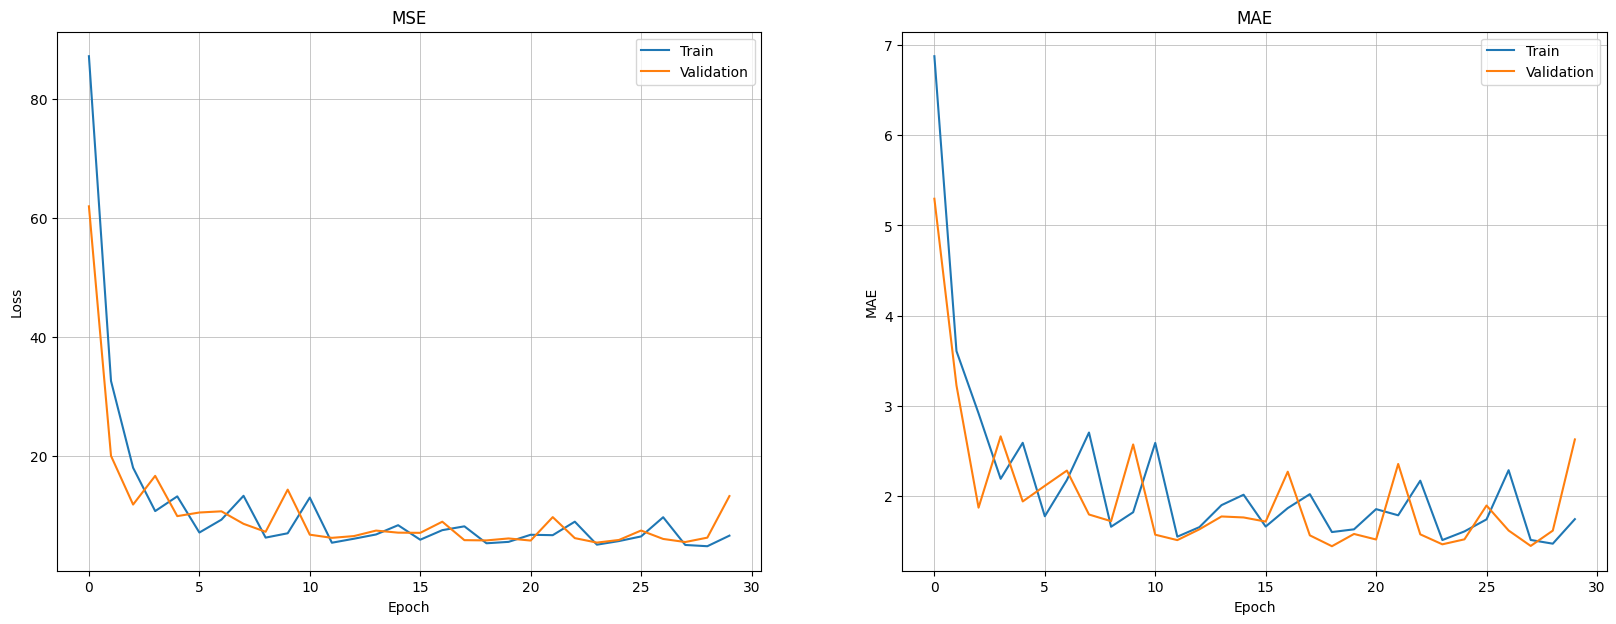

In [ ]:
plot_history(history)

In [ ]:
import pickle

save = False 

if save :
    # Export Pipeline as pickle file
    with open("model.pkl", "wb") as file:
        pickle.dump(model, file)


INFO:tensorflow:Assets written to: ram://b8966690-a52f-4663-85a1-3ee4ad63ae52/assets


INFO:tensorflow:Assets written to: ram://b8966690-a52f-4663-85a1-3ee4ad63ae52/assets
